# load in leaves dataset

In [1]:
from google.colab import drive

# Mount Google Drive to access files and folders
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/Thesis code 2/healthy_scab_LDs/'
train_path = '/content/drive/MyDrive/Thesis code 2/healthy_scab_LDs/training/'
val_path = '/content/drive/MyDrive/Thesis code 2/healthy_scab_LDs/validation/'
train_val_path = '/content/drive/MyDrive/Thesis code 2/healthy_scab_LDs/train_val'
test_path = '/content/drive/MyDrive/Thesis code 2/healthy_scab_LDs/test/'

# Download and import libraries

In [3]:
!pip install timm
!pip install optuna
!pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import os
import numpy as np

from optuna.trial import TrialState
import optuna
import timm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

from torchvision import datasets
from torchvision import transforms
from torchvision.datasets import ImageFolder

import imblearn.metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Create reproducible results

In [5]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed()

Random seed set as 42


# Calculating pos weight

In [6]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Calculate class weight train
train_dataset = ImageFolder(train_path)
train_targets = train_dataset.targets
train_class_counts = torch.bincount(torch.tensor(train_targets))

train_total_negative_samples = train_class_counts[0].item()
train_total_positive_samples = train_class_counts[1].item()

train_pos_weight = train_total_negative_samples / train_total_positive_samples

# Put class weight in tensor
train_pos_weight_tensor = torch.tensor(train_pos_weight)
train_pos_weight_tensor = train_pos_weight_tensor.to(DEVICE)
print(train_pos_weight_tensor)

tensor(0.4211, device='cuda:0')


In [7]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Calculate class weight train_val dataset
train_val_dataset = ImageFolder(train_val_path)
train_val_targets = train_val_dataset.targets
train_val_class_counts = torch.bincount(torch.tensor(train_val_targets))

train_val_total_negative_samples = train_val_class_counts[0].item()
train_val_total_positive_samples = train_val_class_counts[1].item()

train_val_pos_weight = train_val_total_negative_samples / train_val_total_positive_samples

# Put class weight in tensor
train_val_pos_weight_tensor = torch.tensor(train_val_pos_weight)
train_val_pos_weight_tensor = train_val_pos_weight_tensor.to(DEVICE)
print(train_val_pos_weight_tensor)

tensor(0.4204, device='cuda:0')


# MaxViT model

In [ ]:
timm.list_models('*maxvit*', pretrained=True) # 'maxvit_tiny_tf_224.in1k', (resnet pretrained on imagenet 1k with input size 224x224)

['maxvit_base_tf_224.in1k',
 'maxvit_base_tf_224.in21k',
 'maxvit_base_tf_384.in1k',
 'maxvit_base_tf_384.in21k_ft_in1k',
 'maxvit_base_tf_512.in1k',
 'maxvit_base_tf_512.in21k_ft_in1k',
 'maxvit_large_tf_224.in1k',
 'maxvit_large_tf_224.in21k',
 'maxvit_large_tf_384.in1k',
 'maxvit_large_tf_384.in21k_ft_in1k',
 'maxvit_large_tf_512.in1k',
 'maxvit_large_tf_512.in21k_ft_in1k',
 'maxvit_nano_rw_256.sw_in1k',
 'maxvit_rmlp_base_rw_224.sw_in12k',
 'maxvit_rmlp_base_rw_224.sw_in12k_ft_in1k',
 'maxvit_rmlp_base_rw_384.sw_in12k_ft_in1k',
 'maxvit_rmlp_nano_rw_256.sw_in1k',
 'maxvit_rmlp_pico_rw_256.sw_in1k',
 'maxvit_rmlp_small_rw_224.sw_in1k',
 'maxvit_rmlp_tiny_rw_256.sw_in1k',
 'maxvit_small_tf_224.in1k',
 'maxvit_small_tf_384.in1k',
 'maxvit_small_tf_512.in1k',
 'maxvit_tiny_rw_224.sw_in1k',
 'maxvit_tiny_tf_224.in1k',
 'maxvit_tiny_tf_384.in1k',
 'maxvit_tiny_tf_512.in1k',
 'maxvit_xlarge_tf_224.in21k',
 'maxvit_xlarge_tf_384.in21k_ft_in1k',
 'maxvit_xlarge_tf_512.in21k_ft_in1k']

## Do hyperparameter tuning MaxViT model

In [ ]:
# Set device and parameters
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCHSIZE = 32
epochs = 100


def define_model(trial):
  model = timm.create_model('maxvit_tiny_tf_224.in1k', pretrained=True, in_chans=3)

  for param in model.parameters():
    param.requires_grad = False

  num_in_features = model.get_classifier().in_features

  head = []
  first_neuron = trial.suggest_categorical('first_neuron', [128, 256, 512, 768])
  head.append(nn.Linear(in_features=num_in_features, out_features=first_neuron))
  head.append(nn.ReLU())
  drop_out = trial.suggest_categorical('drop_out', [0, 0.3, 0.5])
  head.append(nn.Dropout(p=drop_out))
  num_in_features = first_neuron

  head.append(nn.Linear(in_features=num_in_features, out_features=1))

  model.head.fc = nn.Sequential(*head)

  for param in model.head.parameters():
    param.requires_grad = True

  return model


def get_dataset():

  transform_train = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

  transform_valid = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ])

  train_dataset = ImageFolder(train_path, transform=transform_train)
  val_dataset = ImageFolder(val_path, transform=transform_valid)

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCHSIZE, shuffle=True)
  valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCHSIZE, shuffle=False)

  return train_loader, valid_loader


def objective(trial):

  # Send model to the device
  model = define_model(trial).to(DEVICE)

  # Define optimizer and loss function
  optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "AdamW"])
  learning_rate = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
  weightdecay = trial.suggest_float("weightdecay", low=0.001, high=0.01, log=True)

  if optimizer_name == 'RMSprop':
    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weightdecay)
  elif optimizer_name == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weightdecay)
  elif optimizer_name == 'AdamW':
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weightdecay)


  use_pos_weight = trial.suggest_categorical("use_pos_weight", [True, False])

  if use_pos_weight is True:
    criterion = nn.BCEWithLogitsLoss(pos_weight=train_pos_weight_tensor)
  else:
    criterion = nn.BCEWithLogitsLoss()

  # Load in dataset
  train_loader, valid_loader = get_dataset()

  # Initialize variables for early stopping
  best_loss = 1000000
  patience = 5
  no_improvement_count = 0


  # Training
  for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    y_true = []
    y_pred = []


    for i in train_loader:
        #LOADING THE DATA IN A BATCH
        data, target = i

        # moving the tensors to the configured device
        data, target = data.to(DEVICE), target.to(DEVICE)

        #FORWARD PASS
        target = target.float()
        output = model(data.float())
        loss = criterion(output, target.unsqueeze(1))

        train_loss += loss.item() * data.size(0)

        #BACKWARD AND OPTIMIZE
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        #PREDICTIONS BCELogitsloss()
        pred = torch.round(torch.sigmoid(output.detach()))
        y_true.extend(target.tolist())
        y_pred.extend(pred.reshape(-1).tolist())

    train_loss /= len(train_loader.sampler)
    train_accuracy = accuracy_score(y_true, y_pred)

    cm = confusion_matrix(y_true, y_pred)

    # Extract the elements of the confusion matrix
    tn, fp, fn, tp = cm.ravel()

    # Calculate specificity and sensitivity
    train_specificity = tn / (tn + fp)
    train_sensitivity = tp / (tp + fn)

    train_gmean = imblearn.metrics.geometric_mean_score(y_true, y_pred)


    # Evaluation:

    #model in eval mode skips Dropout etc
    model.eval()
    valid_loss = 0.0
    y_true = []
    y_pred = []

    # set the requires_grad flag to false as we are in the test mode
    with torch.no_grad():
        for i in valid_loader:

            #LOAD THE DATA IN A BATCH
            data, target = i

            # moving the tensors to the configured device
            data, target = data.to(DEVICE), target.to(DEVICE)

            target = target.float()
            output = model(data.float())

            loss = criterion(output, target.unsqueeze(1))
            valid_loss += loss.item() * data.size(0)


            #PREDICTIONS
            pred = torch.round(torch.sigmoid(output))
            y_true.extend(target.tolist())
            y_pred.extend(pred.reshape(-1).tolist())

    valid_loss /= len(valid_loader.sampler)
    valid_accuracy = accuracy_score(y_true,y_pred)

    # get the specificity, sensitivity and g-mean
    cm = confusion_matrix(y_true, y_pred)

    # Extract the elements of the confusion matrix
    tn, fp, fn, tp = cm.ravel()

    # Calculate specificity and sensitivity
    valid_specificity = tn / (tn + fp)
    valid_sensitivity = tp / (tp + fn)

    valid_gmean = imblearn.metrics.geometric_mean_score(y_true, y_pred)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}% "
          f"Train specificity: {train_specificity:.4f}, Train sensitivity: {train_sensitivity:.4f} Train g_mean: {train_gmean:.4f}% ----> "
          f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f} %"
          f"Valid specificity: {valid_specificity:.4f}, Valid sensitivity: {valid_sensitivity:.4f} Valid g_mean: {valid_gmean:.4f}")

    # Early stopping
    if valid_loss < best_loss:
        best_loss = valid_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    if no_improvement_count >= patience:
        print("Early stopping criterion met at epoch {}".format(epoch))
        break

    # Pruning
    if trial.should_prune():
        raise optuna.TrialPruned()

    # Report the intermediate result
    trial.report(valid_gmean, epoch)

  return valid_gmean


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=10)

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2023-06-13 21:26:23,525] A new study created in memory with name: no-name-e9cae186-f4b3-4595-ab9a-ba78536962f1


Epoch [1/100], Train Loss: 6.7442, Train Accuracy: 0.6225% Train specificity: 0.3347, Train sensitivity: 0.7436 Train g_mean: 0.4989% ----> Valid Loss: 0.8744, Valid Accuracy: 0.3544 %Valid specificity: 0.9756, Valid sensitivity: 0.2245 Valid g_mean: 0.4680
Epoch [2/100], Train Loss: 0.5282, Train Accuracy: 0.7360% Train specificity: 0.3911, Train sensitivity: 0.8812 Train g_mean: 0.5871% ----> Valid Loss: 0.4164, Valid Accuracy: 0.8523 %Valid specificity: 0.6341, Valid sensitivity: 0.8980 Valid g_mean: 0.7546
Epoch [3/100], Train Loss: 0.4432, Train Accuracy: 0.7897% Train specificity: 0.5726, Train sensitivity: 0.8812 Train g_mean: 0.7103% ----> Valid Loss: 1.0388, Valid Accuracy: 0.5781 %Valid specificity: 0.9024, Valid sensitivity: 0.5102 Valid g_mean: 0.6785
Epoch [4/100], Train Loss: 0.4358, Train Accuracy: 0.7873% Train specificity: 0.5968, Train sensitivity: 0.8676 Train g_mean: 0.7195% ----> Valid Loss: 0.5433, Valid Accuracy: 0.8312 %Valid specificity: 0.0244, Valid sensitivi

[I 2023-06-13 22:37:31,419] Trial 0 finished with value: 0.7296262092172299 and parameters: {'first_neuron': 768, 'drop_out': 0.5, 'optimizer': 'RMSprop', 'lr': 0.0034570568539960185, 'weightdecay': 0.0030350217859227086, 'use_pos_weight': False}. Best is trial 0 with value: 0.7296262092172299.


Epoch [12/100], Train Loss: 0.4026, Train Accuracy: 0.8292% Train specificity: 0.6694, Train sensitivity: 0.8964 Train g_mean: 0.7746% ----> Valid Loss: 0.4711, Valid Accuracy: 0.7131 %Valid specificity: 0.7561, Valid sensitivity: 0.7041 Valid g_mean: 0.7296
Early stopping criterion met at epoch 11
Epoch [1/100], Train Loss: 0.3850, Train Accuracy: 0.6703% Train specificity: 0.6411, Train sensitivity: 0.6825 Train g_mean: 0.6615% ----> Valid Loss: 0.3488, Valid Accuracy: 0.4557 %Valid specificity: 0.9512, Valid sensitivity: 0.3520 Valid g_mean: 0.5787
Epoch [2/100], Train Loss: 0.3495, Train Accuracy: 0.7443% Train specificity: 0.7621, Train sensitivity: 0.7368 Train g_mean: 0.7494% ----> Valid Loss: 0.3164, Valid Accuracy: 0.6667 %Valid specificity: 0.8293, Valid sensitivity: 0.6327 Valid g_mean: 0.7243
Epoch [3/100], Train Loss: 0.3248, Train Accuracy: 0.7622% Train specificity: 0.7258, Train sensitivity: 0.7776 Train g_mean: 0.7513% ----> Valid Loss: 0.3436, Valid Accuracy: 0.4852 %

[I 2023-06-14 00:34:58,757] Trial 1 finished with value: 0.7880863781165249 and parameters: {'first_neuron': 128, 'drop_out': 0.3, 'optimizer': 'RMSprop', 'lr': 0.00011165667429377995, 'weightdecay': 0.0018433402652725905, 'use_pos_weight': True}. Best is trial 1 with value: 0.7880863781165249.


Epoch [21/100], Train Loss: 0.2059, Train Accuracy: 0.8554% Train specificity: 0.8589, Train sensitivity: 0.8540 Train g_mean: 0.8564% ----> Valid Loss: 0.2183, Valid Accuracy: 0.8101 %Valid specificity: 0.7561, Valid sensitivity: 0.8214 Valid g_mean: 0.7881
Early stopping criterion met at epoch 20
Epoch [1/100], Train Loss: 0.5509, Train Accuracy: 0.7384% Train specificity: 0.2218, Train sensitivity: 0.9559 Train g_mean: 0.4604% ----> Valid Loss: 0.7562, Valid Accuracy: 0.4726 %Valid specificity: 0.9512, Valid sensitivity: 0.3724 Valid g_mean: 0.5952
Epoch [2/100], Train Loss: 0.4607, Train Accuracy: 0.7814% Train specificity: 0.5927, Train sensitivity: 0.8608 Train g_mean: 0.7143% ----> Valid Loss: 0.4691, Valid Accuracy: 0.7764 %Valid specificity: 0.6829, Valid sensitivity: 0.7959 Valid g_mean: 0.7373
Epoch [3/100], Train Loss: 0.4073, Train Accuracy: 0.8160% Train specificity: 0.6371, Train sensitivity: 0.8913 Train g_mean: 0.7536% ----> Valid Loss: 0.4385, Valid Accuracy: 0.8017 %

[I 2023-06-14 01:51:36,630] Trial 2 finished with value: 0.8170044472335525 and parameters: {'first_neuron': 256, 'drop_out': 0.5, 'optimizer': 'Adam', 'lr': 0.0016203514739222104, 'weightdecay': 0.004297001847105464, 'use_pos_weight': False}. Best is trial 2 with value: 0.8170044472335525.


Epoch [14/100], Train Loss: 0.3323, Train Accuracy: 0.8495% Train specificity: 0.6653, Train sensitivity: 0.9270 Train g_mean: 0.7853% ----> Valid Loss: 0.4469, Valid Accuracy: 0.7806 %Valid specificity: 0.8780, Valid sensitivity: 0.7602 Valid g_mean: 0.8170
Early stopping criterion met at epoch 13
Epoch [1/100], Train Loss: 0.5268, Train Accuracy: 0.7336% Train specificity: 0.2500, Train sensitivity: 0.9372 Train g_mean: 0.4840% ----> Valid Loss: 0.3985, Valid Accuracy: 0.8692 %Valid specificity: 0.4878, Valid sensitivity: 0.9490 Valid g_mean: 0.6804
Epoch [2/100], Train Loss: 0.4214, Train Accuracy: 0.8112% Train specificity: 0.5242, Train sensitivity: 0.9321 Train g_mean: 0.6990% ----> Valid Loss: 0.3423, Valid Accuracy: 0.8692 %Valid specificity: 0.5366, Valid sensitivity: 0.9388 Valid g_mean: 0.7097
Epoch [3/100], Train Loss: 0.4032, Train Accuracy: 0.8184% Train specificity: 0.5887, Train sensitivity: 0.9151 Train g_mean: 0.7340% ----> Valid Loss: 0.3354, Valid Accuracy: 0.8608 %

[I 2023-06-14 02:43:05,407] Trial 3 finished with value: 0.79320157631399 and parameters: {'first_neuron': 512, 'drop_out': 0, 'optimizer': 'RMSprop', 'lr': 0.00017783550103931333, 'weightdecay': 0.0013934235179031062, 'use_pos_weight': False}. Best is trial 2 with value: 0.8170044472335525.


Epoch [10/100], Train Loss: 0.2862, Train Accuracy: 0.8925% Train specificity: 0.7944, Train sensitivity: 0.9338 Train g_mean: 0.8613% ----> Valid Loss: 0.4330, Valid Accuracy: 0.8017 %Valid specificity: 0.7805, Valid sensitivity: 0.8061 Valid g_mean: 0.7932
Early stopping criterion met at epoch 9
Epoch [1/100], Train Loss: 0.3925, Train Accuracy: 0.5675% Train specificity: 0.7339, Train sensitivity: 0.4975 Train g_mean: 0.6042% ----> Valid Loss: 0.3361, Valid Accuracy: 0.6160 %Valid specificity: 0.9024, Valid sensitivity: 0.5561 Valid g_mean: 0.7084
Epoch [2/100], Train Loss: 0.3463, Train Accuracy: 0.7407% Train specificity: 0.7379, Train sensitivity: 0.7419 Train g_mean: 0.7399% ----> Valid Loss: 0.3261, Valid Accuracy: 0.5907 %Valid specificity: 0.9268, Valid sensitivity: 0.5204 Valid g_mean: 0.6945
Epoch [3/100], Train Loss: 0.3056, Train Accuracy: 0.7646% Train specificity: 0.8105, Train sensitivity: 0.7453 Train g_mean: 0.7772% ----> Valid Loss: 0.2935, Valid Accuracy: 0.6835 %V

[I 2023-06-14 04:03:11,643] Trial 4 finished with value: 0.7900576813566098 and parameters: {'first_neuron': 768, 'drop_out': 0.3, 'optimizer': 'Adam', 'lr': 0.00019710983920310032, 'weightdecay': 0.0020507792518224166, 'use_pos_weight': True}. Best is trial 2 with value: 0.8170044472335525.


Epoch [15/100], Train Loss: 0.1843, Train Accuracy: 0.8626% Train specificity: 0.8548, Train sensitivity: 0.8659 Train g_mean: 0.8603% ----> Valid Loss: 0.2284, Valid Accuracy: 0.7806 %Valid specificity: 0.8049, Valid sensitivity: 0.7755 Valid g_mean: 0.7901
Early stopping criterion met at epoch 14
Epoch [1/100], Train Loss: 0.3606, Train Accuracy: 0.6499% Train specificity: 0.6694, Train sensitivity: 0.6418 Train g_mean: 0.6554% ----> Valid Loss: 0.2730, Valid Accuracy: 0.7426 %Valid specificity: 0.8780, Valid sensitivity: 0.7143 Valid g_mean: 0.7919
Epoch [2/100], Train Loss: 0.2856, Train Accuracy: 0.7611% Train specificity: 0.8387, Train sensitivity: 0.7284 Train g_mean: 0.7816% ----> Valid Loss: 0.4102, Valid Accuracy: 0.4557 %Valid specificity: 0.9512, Valid sensitivity: 0.3520 Valid g_mean: 0.5787
Epoch [3/100], Train Loss: 0.2512, Train Accuracy: 0.7969% Train specificity: 0.8185, Train sensitivity: 0.7878 Train g_mean: 0.8030% ----> Valid Loss: 0.2944, Valid Accuracy: 0.6498 %

[I 2023-06-14 04:50:36,824] Trial 5 finished with value: 0.7605243010867924 and parameters: {'first_neuron': 256, 'drop_out': 0, 'optimizer': 'AdamW', 'lr': 0.0012009861413696946, 'weightdecay': 0.004205325651280322, 'use_pos_weight': True}. Best is trial 2 with value: 0.8170044472335525.


Epoch [9/100], Train Loss: 0.1608, Train Accuracy: 0.8746% Train specificity: 0.8790, Train sensitivity: 0.8727 Train g_mean: 0.8758% ----> Valid Loss: 0.2384, Valid Accuracy: 0.8186 %Valid specificity: 0.6829, Valid sensitivity: 0.8469 Valid g_mean: 0.7605
Early stopping criterion met at epoch 8
Epoch [1/100], Train Loss: 0.3964, Train Accuracy: 0.6619% Train specificity: 0.5605, Train sensitivity: 0.7046 Train g_mean: 0.6284% ----> Valid Loss: 0.3617, Valid Accuracy: 0.3586 %Valid specificity: 0.9756, Valid sensitivity: 0.2296 Valid g_mean: 0.4733


[I 2023-06-14 05:01:42,283] Trial 6 pruned. 


Epoch [2/100], Train Loss: 0.3659, Train Accuracy: 0.7348% Train specificity: 0.7137, Train sensitivity: 0.7436 Train g_mean: 0.7285% ----> Valid Loss: 0.3501, Valid Accuracy: 0.4219 %Valid specificity: 0.9268, Valid sensitivity: 0.3163 Valid g_mean: 0.5415
Epoch [1/100], Train Loss: 0.5294, Train Accuracy: 0.7515% Train specificity: 0.2984, Train sensitivity: 0.9423 Train g_mean: 0.5302% ----> Valid Loss: 0.3776, Valid Accuracy: 0.8439 %Valid specificity: 0.0976, Valid sensitivity: 1.0000 Valid g_mean: 0.3123


[I 2023-06-14 05:12:36,536] Trial 7 pruned. 


Epoch [2/100], Train Loss: 0.4482, Train Accuracy: 0.8017% Train specificity: 0.4839, Train sensitivity: 0.9355 Train g_mean: 0.6728% ----> Valid Loss: 0.8119, Valid Accuracy: 0.4515 %Valid specificity: 0.9512, Valid sensitivity: 0.3469 Valid g_mean: 0.5745
Epoch [1/100], Train Loss: 0.5653, Train Accuracy: 0.7133% Train specificity: 0.1129, Train sensitivity: 0.9660 Train g_mean: 0.3303% ----> Valid Loss: 0.4262, Valid Accuracy: 0.8565 %Valid specificity: 0.2439, Valid sensitivity: 0.9847 Valid g_mean: 0.4901


[I 2023-06-14 05:23:20,938] Trial 8 pruned. 


Epoch [2/100], Train Loss: 0.4657, Train Accuracy: 0.7885% Train specificity: 0.4234, Train sensitivity: 0.9423 Train g_mean: 0.6316% ----> Valid Loss: 0.3620, Valid Accuracy: 0.8734 %Valid specificity: 0.6341, Valid sensitivity: 0.9235 Valid g_mean: 0.7653
Epoch [1/100], Train Loss: 0.7426, Train Accuracy: 0.6870% Train specificity: 0.2823, Train sensitivity: 0.8574 Train g_mean: 0.4919% ----> Valid Loss: 0.3951, Valid Accuracy: 0.8439 %Valid specificity: 0.2195, Valid sensitivity: 0.9745 Valid g_mean: 0.4625


[I 2023-06-14 05:34:07,686] Trial 9 pruned. 


Epoch [2/100], Train Loss: 0.4584, Train Accuracy: 0.7778% Train specificity: 0.5202, Train sensitivity: 0.8862 Train g_mean: 0.6790% ----> Valid Loss: 0.5758, Valid Accuracy: 0.6667 %Valid specificity: 0.9512, Valid sensitivity: 0.6071 Valid g_mean: 0.7600
Study statistics: 
  Number of finished trials:  10
  Number of pruned trials:  4
  Number of complete trials:  6
Best trial:
  Value:  0.8170044472335525
  Params: 
    first_neuron: 256
    drop_out: 0.5
    optimizer: Adam
    lr: 0.0016203514739222104
    weightdecay: 0.004297001847105464
    use_pos_weight: False


In [ ]:
trials_df = study.trials_dataframe()
trials_df

,number,value,datetime_start,datetime_complete,duration,params_drop_out,params_first_neuron,params_lr,params_optimizer,params_use_pos_weight,params_weightdecay,state
0,0,0.729626,2023-06-13 21:26:23.532412,2023-06-13 22:37:31.419434,0 days 01:11:07.887022,0.5,768,0.003457,RMSprop,False,0.003035,COMPLETE
1,1,0.788086,2023-06-13 22:37:31.420935,2023-06-14 00:34:58.757092,0 days 01:57:27.336157,0.3,128,0.000112,RMSprop,True,0.001843,COMPLETE
2,2,0.817004,2023-06-14 00:34:58.759795,2023-06-14 01:51:36.629392,0 days 01:16:37.869597,0.5,256,0.001620,Adam,False,0.004297,COMPLETE
3,3,0.793202,2023-06-14 01:51:36.634882,2023-06-14 02:43:05.407289,0 days 00:51:28.772407,0.0,512,0.000178,RMSprop,False,0.001393,COMPLETE
4,4,0.790058,2023-06-14 02:43:05.408910,2023-06-14 04:03:11.642795,0 days 01:20:06.233885,0.3,768,0.000197,Adam,True,0.002051,COMPLETE
5,5,0.760524,2023-06-14 04:03:11.644483,2023-06-14 04:50:36.824179,0 days 00:47:25.179696,0.0,256,0.001201,AdamW,True,0.004205,COMPLETE
6,6,0.473278,2023-06-14 04:50:36.825805,2023-06-14 05:01:42.283183,0 days 00:11:05.457378,0.3,128,0.000197,AdamW,True,0.009301,PRUNED
7,7,0.312348,2023-06-14 05:01:42.285705,2023-06-14 05:12:36.536291,0 days 00:10:54.250586,0.0,768,0.000287,RMSprop,False,0.007581,PRUNED
8,8,0.490071,2023-06-14 05:12:36.537527,2023-06-14 05:23:20.938521,0 days 00:10:44.400994,0.0,128,0.000766,Adam,False,0.006253,PRUNED
9,9,0.462507,2023-06-14 05:23:20.939799,2023-06-14 05:34:07.686491,0 days 00:10:46.746692,0.3,768,0.001351,RMSprop,False,0.001104,PRUNED


In [ ]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

In [ ]:
from google.colab import runtime
runtime.unassign()

## Train the MaxViT model with the best hyperparameters (on combined training and validation dataset)

In [15]:
BATCHSIZE = 32
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

best_neurons = 256
best_dropout = 0.5
best_optimizer = 'Adam'
best_lr = 0.001620
epochs = 14
weight_decay = 0.004297
use_pos_weight = False



def define_model():
  model = timm.create_model('maxvit_tiny_tf_224.in1k', pretrained=True, in_chans=3)

  for param in model.parameters():
    param.requires_grad = False


  num_in_features = model.get_classifier().in_features

  head = []
  head.append(nn.Linear(in_features=num_in_features, out_features=best_neurons))
  head.append(nn.ReLU())
  head.append(nn.Dropout(p=best_dropout))
  num_in_features = best_neurons

  head.append(nn.Linear(in_features=num_in_features, out_features=1))

  model.head.fc = nn.Sequential(*head)

  for param in model.head.parameters():
    param.requires_grad = True

  return model


def get_dataset():

  transform_train = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

  transform_valid = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ])

  train_val_dataset = ImageFolder(train_val_path, transform=transform_train)
  test_dataset = ImageFolder(test_path, transform=transform_valid) # Test dataset only used to see learning curve (no hp tuning)

  train_val_loader = torch.utils.data.DataLoader(train_val_dataset, batch_size=BATCHSIZE, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCHSIZE, shuffle=False)

  return train_val_loader, test_loader


# Send model to the device
model = define_model().to(DEVICE)

# Define optimizer and loss function
if best_optimizer == 'RMSprop':
  optimizer = torch.optim.RMSprop(model.parameters(), lr=best_lr, weight_decay=weight_decay)
elif best_optimizer == 'Adam':
  optimizer = torch.optim.Adam(model.parameters(), lr=best_lr, weight_decay=weight_decay)
elif best_optimizer == 'AdamW':
  optimizer = torch.optim.AdamW(model.parameters(), lr=best_lr, weight_decay=weight_decay)

if use_pos_weight is True:
  criterion = nn.BCEWithLogitsLoss(pos_weight=train_pos_weight_tensor)
else:
  criterion = nn.BCEWithLogitsLoss()

# Load in dataset
train_val_loader, test_loader = get_dataset()

# Initialize variables for early stopping
best_loss = 1000000
patience = 5
no_improvement_count = 0

# train_val
train_val_losses = []
train_val_accuracies = []
test_losses = []
test_accuracies = []

# Training
for epoch in range(epochs):
  model.train()
  train_val_loss = 0.0
  y_true = []
  y_pred = []


  for i in train_val_loader:
      #LOADING THE DATA IN A BATCH
      data, target = i

      # moving the tensors to the configured device
      data, target = data.to(DEVICE), target.to(DEVICE)

      #FORWARD PASS
      target = target.float()
      output = model(data.float())
      loss = criterion(output, target.unsqueeze(1))

      train_val_loss += loss.item() * data.size(0)

      #BACKWARD AND OPTIMIZE
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


      #PREDICTIONS BCELogitsloss()
      pred = torch.round(torch.sigmoid(output.detach()))
      y_true.extend(target.tolist())
      y_pred.extend(pred.reshape(-1).tolist())

  train_val_loss /= len(train_val_loader.sampler)
  train_val_accuracy = accuracy_score(y_true, y_pred)

  train_val_losses.append(train_val_loss)
  train_val_accuracies.append(train_val_accuracy)

  cm = confusion_matrix(y_true, y_pred)

  # Extract the elements of the confusion matrix
  tn, fp, fn, tp = cm.ravel()

  # Calculate specificity and sensitivity
  train_val_specificity = tn / (tn + fp)
  train_val_sensitivity = tp / (tp + fn)

  train_val_gmean = imblearn.metrics.geometric_mean_score(y_true, y_pred)

  # Evaluation:

   #model in eval mode skips Dropout etc
  model.eval()
  test_loss = 0.0
  y_true = []
  y_pred = []

  # set the requires_grad flag to false as we are in the test mode
  with torch.no_grad():
      for i in test_loader:

          #LOAD THE DATA IN A BATCH
          data, target = i

          # moving the tensors to the configured device
          data, target = data.to(DEVICE), target.to(DEVICE)

          target = target.float()
          output = model(data.float())

          loss = criterion(output, target.unsqueeze(1))
          test_loss += loss.item() * data.size(0)


          #PREDICTIONS
          pred = torch.round(torch.sigmoid(output))
          y_true.extend(target.tolist())
          y_pred.extend(pred.reshape(-1).tolist())

  test_loss /= len(test_loader.sampler)
  test_accuracy = accuracy_score(y_true, y_pred)

  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)

  # get the specificity, sensitivity and g-mean
  cm = confusion_matrix(y_true, y_pred)

  # Extract the elements of the confusion matrix
  tn, fp, fn, tp = cm.ravel()

  # Calculate specificity and sensitivity
  test_specificity = tn / (tn + fp)
  test_sensitivity = tp / (tp + fn)

  test_gmean = imblearn.metrics.geometric_mean_score(y_true, y_pred)

  print(f"Epoch [{epoch+1}/{epochs}], Train_val Loss: {train_val_loss:.4f}, Train_val Accuracy: {train_val_accuracy:.4f}%, "
        f"Train_val specificity: {train_val_specificity:.4f}, Train_val sensitivity: {train_val_sensitivity:.4f}, Train_val g_mean: {train_val_gmean:.4f}% ----> "
        f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}%, "
        f"Test specificity: {test_specificity:.4f}, Test sensitivity: {test_sensitivity:.4f}, Test g_mean: {test_gmean:.4f}")

Epoch [1/14], Train_val Loss: 0.5522, Train_val Accuracy: 0.7309%, Train_val specificity: 0.2515, Train_val sensitivity: 0.9325, Train_val g_mean: 0.4843% ----> Test Loss: 0.3745, Test Accuracy: 0.8750%, Test specificity: 0.5238, Test sensitivity: 0.9495, Test g_mean: 0.7052
Epoch [2/14], Train_val Loss: 0.4229, Train_val Accuracy: 0.8117%, Train_val specificity: 0.6000, Train_val sensitivity: 0.9006, Train_val g_mean: 0.7351% ----> Test Loss: 0.5355, Test Accuracy: 0.6958%, Test specificity: 0.7857, Test sensitivity: 0.6768, Test g_mean: 0.7292
Epoch [3/14], Train_val Loss: 0.3943, Train_val Accuracy: 0.8296%, Train_val specificity: 0.6273, Train_val sensitivity: 0.9146, Train_val g_mean: 0.7575% ----> Test Loss: 0.5232, Test Accuracy: 0.7083%, Test specificity: 0.8095, Test sensitivity: 0.6869, Test g_mean: 0.7457
Epoch [4/14], Train_val Loss: 0.3914, Train_val Accuracy: 0.8179%, Train_val specificity: 0.6030, Train_val sensitivity: 0.9083, Train_val g_mean: 0.7401% ----> Test Loss: 

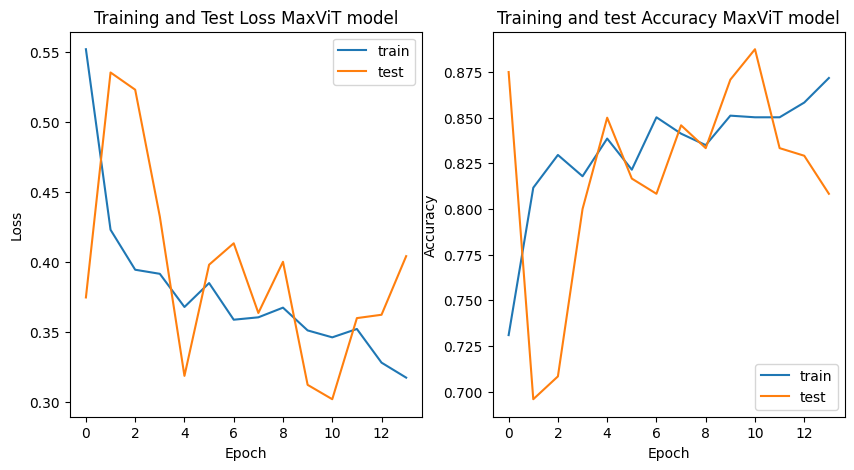

In [16]:
# Plot the validation and training loss and accuracy values
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(train_val_losses, label='train')
ax[0].plot(test_losses, label='test')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training and Test Loss MaxViT model')
ax[0].legend()
ax[1].plot(train_val_accuracies, label='train')
ax[1].plot(test_accuracies, label='test')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Training and test Accuracy MaxViT model')
ax[1].legend()
plt.show()

## Test performance MaxViT model

In [17]:
# load in testset
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = ImageFolder(test_path, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

In [18]:
model.eval()
test_loss = 0.0
y_true = []
y_pred = []
Y_pred_prob = []

with torch.no_grad():
   for i in test_loader:

          #LOAD THE DATA IN A BATCH
          data, target = i

          # moving the tensors to the configured device
          data, target = data.to(DEVICE), target.to(DEVICE)

          target = target.float()
          output = model(data.float())

          loss = criterion(output, target.unsqueeze(1))
          test_loss += loss.item() * data.size(0)


          #PREDICTIONS
          pred_prop = torch.sigmoid(output)
          pred = torch.round(torch.sigmoid(output))

          y_true.extend(target.tolist())
          y_pred.extend(pred.reshape(-1).tolist())
          Y_pred_prob.extend(pred_prop.reshape(-1).tolist())

test_loss /= len(test_loader.sampler)
test_accuracy = accuracy_score(y_true,y_pred)

# get the specificity, sensitivity and g-mean
cm = confusion_matrix(y_true, y_pred)

# Extract the elements of the confusion matrix
tn, fp, fn, tp = cm.ravel()

# Calculate specificity and sensitivity
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

g_mean = imblearn.metrics.geometric_mean_score(y_true, y_pred)


print()
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1score = f1_score(y_true, y_pred)
f1score_macro = f1_score(y_true, y_pred, average = 'macro')
auc_roc = roc_auc_score(y_true, Y_pred_prob)

# Print the evaluation metrics
print('Test_loss:', test_loss)
print('Accuracy:', test_accuracy)
print()

print('Specificity:', specificity)
print('Sensitivity:', sensitivity)
print('g_mean:', g_mean)
print()

print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1score)
print('F1_score_macro:', f1score_macro)
print('AUC-ROC:', auc_roc)
print()

print(classification_report(y_true, y_pred))


Test_loss: 0.4040616671244303
Accuracy: 0.8083333333333333

Specificity: 0.7380952380952381
Sensitivity: 0.8232323232323232
g_mean: 0.7795023140593347

Precision: 0.9367816091954023
Recall: 0.8232323232323232
F1-score: 0.8763440860215053
F1_score_macro: 0.7252090800477897
AUC-ROC: 0.8718133718133719

              precision    recall  f1-score   support

         0.0       0.47      0.74      0.57        42
         1.0       0.94      0.82      0.88       198

    accuracy                           0.81       240
   macro avg       0.70      0.78      0.73       240
weighted avg       0.86      0.81      0.82       240



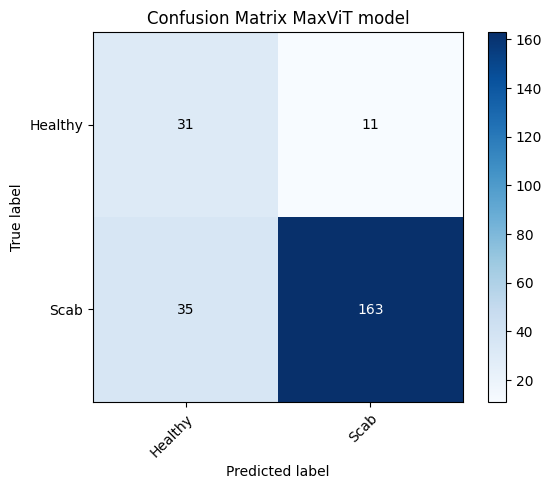

In [19]:
import matplotlib.pyplot as plt

# Create a confusion matrix:
cm = confusion_matrix(y_true, y_pred)

# Define the class labels
classes = np.unique(['Healthy', 'Scab'])

# Create the plot
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Add axis labels and tick marks
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes,
       yticklabels=classes,
       xlabel='Predicted label',
       ylabel='True label')

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2. else "black")

# Add a title and show plot
ax.set_title("Confusion Matrix MaxViT model")
plt.show()

# Swin transformer model

In [8]:
timm.list_models('*swin*', pretrained=True)
# 'swin_tiny_patch4_window7_224.ms_in1k', (swin_tiny_patch4_window7_224 pretrained on imagenet 1k with input size 224x224)

['swin_base_patch4_window7_224.ms_in1k',
 'swin_base_patch4_window7_224.ms_in22k',
 'swin_base_patch4_window7_224.ms_in22k_ft_in1k',
 'swin_base_patch4_window12_384.ms_in1k',
 'swin_base_patch4_window12_384.ms_in22k',
 'swin_base_patch4_window12_384.ms_in22k_ft_in1k',
 'swin_large_patch4_window7_224.ms_in22k',
 'swin_large_patch4_window7_224.ms_in22k_ft_in1k',
 'swin_large_patch4_window12_384.ms_in22k',
 'swin_large_patch4_window12_384.ms_in22k_ft_in1k',
 'swin_s3_base_224.ms_in1k',
 'swin_s3_small_224.ms_in1k',
 'swin_s3_tiny_224.ms_in1k',
 'swin_small_patch4_window7_224.ms_in1k',
 'swin_small_patch4_window7_224.ms_in22k',
 'swin_small_patch4_window7_224.ms_in22k_ft_in1k',
 'swin_tiny_patch4_window7_224.ms_in1k',
 'swin_tiny_patch4_window7_224.ms_in22k',
 'swin_tiny_patch4_window7_224.ms_in22k_ft_in1k',
 'swinv2_base_window8_256.ms_in1k',
 'swinv2_base_window12_192.ms_in22k',
 'swinv2_base_window12to16_192to256.ms_in22k_ft_in1k',
 'swinv2_base_window12to24_192to384.ms_in22k_ft_in1k',


## Do hyperparameter tuning Swin transformer model

In [9]:
# Set device and parameters
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCHSIZE = 32
epochs = 100


def define_model(trial):
  model = timm.create_model('swin_tiny_patch4_window7_224.ms_in1k', pretrained=True, in_chans=3)

  for param in model.parameters():
    param.requires_grad = False

  num_in_features = model.get_classifier().in_features

  head = []
  first_neuron = trial.suggest_categorical('first_neuron', [128, 256, 512, 768])
  head.append(nn.Linear(in_features=num_in_features, out_features=first_neuron))
  head.append(nn.ReLU())
  drop_out = trial.suggest_categorical('drop_out', [0, 0.3, 0.5])
  head.append(nn.Dropout(p=drop_out))
  num_in_features = first_neuron

  head.append(nn.Linear(in_features=num_in_features, out_features=1))

  model.head.fc = nn.Sequential(*head)

  for param in model.head.parameters():
    param.requires_grad = True

  return model


def get_dataset():

  transform_train = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

  transform_valid = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ])

  train_dataset = ImageFolder(train_path, transform=transform_train)
  val_dataset = ImageFolder(val_path, transform=transform_valid)

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCHSIZE, shuffle=True)
  valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCHSIZE, shuffle=True)

  return train_loader, valid_loader


def objective(trial):

  # Send model to the device
  model = define_model(trial).to(DEVICE)

  # Define optimizer and loss function
  optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "AdamW"])
  learning_rate = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
  weightdecay = trial.suggest_float("weightdecay", low=0.001, high=0.01, log=True)

  if optimizer_name == 'RMSprop':
    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weightdecay)
  elif optimizer_name == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weightdecay)
  elif optimizer_name == 'AdamW':
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weightdecay)


  use_pos_weight = trial.suggest_categorical("use_pos_weight", [True, False])

  if use_pos_weight is True:
    criterion = nn.BCEWithLogitsLoss(pos_weight=train_pos_weight_tensor)
  else:
    criterion = nn.BCEWithLogitsLoss()

  # Load in dataset
  train_loader, valid_loader = get_dataset()

  # Initialize variables for early stopping
  best_loss = 1000000
  patience = 5
  no_improvement_count = 0


  # Training
  for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    y_true = []
    y_pred = []


    for i in train_loader:
        #LOADING THE DATA IN A BATCH
        data, target = i

        # moving the tensors to the configured device
        data, target = data.to(DEVICE), target.to(DEVICE)

        #FORWARD PASS
        target = target.float()
        output = model(data.float())
        loss = criterion(output, target.unsqueeze(1))

        train_loss += loss.item() * data.size(0)

        #BACKWARD AND OPTIMIZE
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        #PREDICTIONS BCELogitsloss()
        pred = torch.round(torch.sigmoid(output.detach()))
        y_true.extend(target.tolist())
        y_pred.extend(pred.reshape(-1).tolist())

    train_loss /= len(train_loader.sampler)
    train_accuracy = accuracy_score(y_true, y_pred)

    cm = confusion_matrix(y_true, y_pred)

    # Extract the elements of the confusion matrix
    tn, fp, fn, tp = cm.ravel()

    # Calculate specificity and sensitivity
    train_specificity = tn / (tn + fp)
    train_sensitivity = tp / (tp + fn)

    train_gmean = imblearn.metrics.geometric_mean_score(y_true, y_pred)


    # Evaluation:

    #model in eval mode skips Dropout etc
    model.eval()
    valid_loss = 0.0
    y_true = []
    y_pred = []

    # set the requires_grad flag to false as we are in the test mode
    with torch.no_grad():
        for i in valid_loader:

            #LOAD THE DATA IN A BATCH
            data, target = i

            # moving the tensors to the configured device
            data, target = data.to(DEVICE), target.to(DEVICE)

            target = target.float()
            output = model(data.float())

            loss = criterion(output, target.unsqueeze(1))
            valid_loss += loss.item() * data.size(0)


            #PREDICTIONS
            pred = torch.round(torch.sigmoid(output))
            y_true.extend(target.tolist())
            y_pred.extend(pred.reshape(-1).tolist())

    valid_loss /= len(valid_loader.sampler)
    valid_accuracy = accuracy_score(y_true,y_pred)

    # get the specificity, sensitivity and g-mean
    cm = confusion_matrix(y_true, y_pred)

    # Extract the elements of the confusion matrix
    tn, fp, fn, tp = cm.ravel()

    # Calculate specificity and sensitivity
    valid_specificity = tn / (tn + fp)
    valid_sensitivity = tp / (tp + fn)

    valid_gmean = imblearn.metrics.geometric_mean_score(y_true, y_pred)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}% "
          f"Train specificity: {train_specificity:.4f}, Train sensitivity: {train_sensitivity:.4f} Train g_mean: {train_gmean:.4f}% ----> "
          f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}% "
          f"Valid specificity: {valid_specificity:.4f}, Valid sensitivity: {valid_sensitivity:.4f} Valid g_mean: {valid_gmean:.4f}")

    # Early stopping
    if valid_loss < best_loss:
        best_loss = valid_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    if no_improvement_count >= patience:
        print("Early stopping criterion met at epoch {}".format(epoch))
        break

    # Pruning
    if trial.should_prune():
        raise optuna.TrialPruned()

    # Report the intermediate result
    trial.report(valid_gmean, epoch)

  return valid_gmean


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=10)

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2023-06-15 19:07:00,870] A new study created in memory with name: no-name-29aaf3ef-09fc-4839-8f29-f0a4fdcc2f57
/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch [1/100], Train Loss: 0.5900, Train Accuracy: 0.7168% Train specificity: 0.2097, Train sensitivity: 0.9304 Train g_mean: 0.4417% ----> Valid Loss: 0.3838, Valid Accuracy: 0.8565% Valid specificity: 0.2195, Valid sensitivity: 0.9898 Valid g_mean: 0.4661
Epoch [2/100], Train Loss: 0.4962, Train Accuracy: 0.7754% Train specificity: 0.3548, Train sensitivity: 0.9525 Train g_mean: 0.5814% ----> Valid Loss: 0.3396, Valid Accuracy: 0.8734% Valid specificity: 0.4146, Valid sensitivity: 0.9694 Valid g_mean: 0.6340
Epoch [3/100], Train Loss: 0.4464, Train Accuracy: 0.7981% Train specificity: 0.4960, Train sensitivity: 0.9253 Train g_mean: 0.6774% ----> Valid Loss: 0.3010, Valid Accuracy: 0.8819% Valid specificity: 0.4390, Valid sensitivity: 0.9745 Valid g_mean: 0.6541
Epoch [4/100], Train Loss: 0.4363, Train Accuracy: 0.7981% Train specificity: 0.5000, Train sensitivity: 0.9236 Train g_mean: 0.6796% ----> Valid Loss: 0.3077, Valid Accuracy: 0.8734% Valid specificity: 0.5366, Valid sensitivi

[I 2023-06-15 20:03:19,108] Trial 0 finished with value: 0.5602122189081892 and parameters: {'first_neuron': 512, 'drop_out': 0.5, 'optimizer': 'Adam', 'lr': 0.0013444337453220121, 'weightdecay': 0.0030237209791356343, 'use_pos_weight': False}. Best is trial 0 with value: 0.5602122189081892.


Epoch [10/100], Train Loss: 0.3488, Train Accuracy: 0.8315% Train specificity: 0.6613, Train sensitivity: 0.9032 Train g_mean: 0.7728% ----> Valid Loss: 0.3134, Valid Accuracy: 0.8734% Valid specificity: 0.3171, Valid sensitivity: 0.9898 Valid g_mean: 0.5602
Early stopping criterion met at epoch 9
Epoch [1/100], Train Loss: 0.5766, Train Accuracy: 0.7013% Train specificity: 0.1089, Train sensitivity: 0.9508 Train g_mean: 0.3217% ----> Valid Loss: 0.3880, Valid Accuracy: 0.8354% Valid specificity: 0.0732, Valid sensitivity: 0.9949 Valid g_mean: 0.2698
Epoch [2/100], Train Loss: 0.4962, Train Accuracy: 0.7634% Train specificity: 0.2944, Train sensitivity: 0.9610 Train g_mean: 0.5318% ----> Valid Loss: 0.3555, Valid Accuracy: 0.8523% Valid specificity: 0.2195, Valid sensitivity: 0.9847 Valid g_mean: 0.4649
Epoch [3/100], Train Loss: 0.4631, Train Accuracy: 0.7873% Train specificity: 0.3992, Train sensitivity: 0.9508 Train g_mean: 0.6161% ----> Valid Loss: 0.3336, Valid Accuracy: 0.8565% V

[I 2023-06-15 22:09:38,631] Trial 1 finished with value: 0.5602122189081892 and parameters: {'first_neuron': 256, 'drop_out': 0, 'optimizer': 'RMSprop', 'lr': 0.00016187701730461564, 'weightdecay': 0.0038682487670502366, 'use_pos_weight': False}. Best is trial 0 with value: 0.5602122189081892.


Epoch [25/100], Train Loss: 0.3208, Train Accuracy: 0.8817% Train specificity: 0.7258, Train sensitivity: 0.9474 Train g_mean: 0.8292% ----> Valid Loss: 0.3328, Valid Accuracy: 0.8734% Valid specificity: 0.3171, Valid sensitivity: 0.9898 Valid g_mean: 0.5602
Early stopping criterion met at epoch 24
Epoch [1/100], Train Loss: 0.4367, Train Accuracy: 0.5711% Train specificity: 0.6492, Train sensitivity: 0.5382 Train g_mean: 0.5911% ----> Valid Loss: 0.2855, Valid Accuracy: 0.8312% Valid specificity: 0.2927, Valid sensitivity: 0.9439 Valid g_mean: 0.5256
Epoch [2/100], Train Loss: 0.3288, Train Accuracy: 0.7109% Train specificity: 0.6653, Train sensitivity: 0.7301 Train g_mean: 0.6969% ----> Valid Loss: 0.2390, Valid Accuracy: 0.7848% Valid specificity: 0.6098, Valid sensitivity: 0.8214 Valid g_mean: 0.7077
Epoch [3/100], Train Loss: 0.2819, Train Accuracy: 0.7730% Train specificity: 0.8105, Train sensitivity: 0.7572 Train g_mean: 0.7834% ----> Valid Loss: 0.1974, Valid Accuracy: 0.8312% 

[I 2023-06-15 23:00:39,381] Trial 2 finished with value: 0.8528492928860917 and parameters: {'first_neuron': 768, 'drop_out': 0, 'optimizer': 'AdamW', 'lr': 0.003533067349274539, 'weightdecay': 0.0012079777036715143, 'use_pos_weight': True}. Best is trial 2 with value: 0.8528492928860917.


Epoch [10/100], Train Loss: 0.1841, Train Accuracy: 0.8566% Train specificity: 0.8790, Train sensitivity: 0.8472 Train g_mean: 0.8630% ----> Valid Loss: 0.1819, Valid Accuracy: 0.8523% Valid specificity: 0.8537, Valid sensitivity: 0.8520 Valid g_mean: 0.8528
Early stopping criterion met at epoch 9
Epoch [1/100], Train Loss: 0.7969, Train Accuracy: 0.6930% Train specificity: 0.3589, Train sensitivity: 0.8336 Train g_mean: 0.5470% ----> Valid Loss: 0.4126, Valid Accuracy: 0.8312% Valid specificity: 0.0244, Valid sensitivity: 1.0000 Valid g_mean: 0.1562
Epoch [2/100], Train Loss: 0.6165, Train Accuracy: 0.7133% Train specificity: 0.4234, Train sensitivity: 0.8353 Train g_mean: 0.5947% ----> Valid Loss: 0.4046, Valid Accuracy: 0.8439% Valid specificity: 0.1220, Valid sensitivity: 0.9949 Valid g_mean: 0.3483
Epoch [3/100], Train Loss: 0.6192, Train Accuracy: 0.7336% Train specificity: 0.4476, Train sensitivity: 0.8540 Train g_mean: 0.6182% ----> Valid Loss: 0.5893, Valid Accuracy: 0.6920% V

[I 2023-06-15 23:46:36,907] Trial 3 finished with value: 0.4673245499037661 and parameters: {'first_neuron': 768, 'drop_out': 0.5, 'optimizer': 'Adam', 'lr': 0.009141333083261339, 'weightdecay': 0.0063598887381088485, 'use_pos_weight': False}. Best is trial 2 with value: 0.8528492928860917.


Epoch [9/100], Train Loss: 0.5795, Train Accuracy: 0.7407% Train specificity: 0.4073, Train sensitivity: 0.8812 Train g_mean: 0.5990% ----> Valid Loss: 0.3389, Valid Accuracy: 0.8608% Valid specificity: 0.2195, Valid sensitivity: 0.9949 Valid g_mean: 0.4673
Early stopping criterion met at epoch 8
Epoch [1/100], Train Loss: 0.3922, Train Accuracy: 0.6010% Train specificity: 0.5806, Train sensitivity: 0.6095 Train g_mean: 0.5949% ----> Valid Loss: 0.2863, Valid Accuracy: 0.8523% Valid specificity: 0.2439, Valid sensitivity: 0.9796 Valid g_mean: 0.4888
Epoch [2/100], Train Loss: 0.3562, Train Accuracy: 0.6882% Train specificity: 0.6694, Train sensitivity: 0.6961 Train g_mean: 0.6826% ----> Valid Loss: 0.2665, Valid Accuracy: 0.8439% Valid specificity: 0.5610, Valid sensitivity: 0.9031 Valid g_mean: 0.7118
Epoch [3/100], Train Loss: 0.3367, Train Accuracy: 0.7145% Train specificity: 0.6855, Train sensitivity: 0.7267 Train g_mean: 0.7058% ----> Valid Loss: 0.2522, Valid Accuracy: 0.8565% Va

[I 2023-06-16 01:04:10,778] Trial 4 finished with value: 0.737851670126194 and parameters: {'first_neuron': 128, 'drop_out': 0.5, 'optimizer': 'RMSprop', 'lr': 0.0005508833307875815, 'weightdecay': 0.007788681347314089, 'use_pos_weight': True}. Best is trial 2 with value: 0.8528492928860917.


Epoch [14/100], Train Loss: 0.2670, Train Accuracy: 0.8088% Train specificity: 0.8266, Train sensitivity: 0.8014 Train g_mean: 0.8139% ----> Valid Loss: 0.2803, Valid Accuracy: 0.6751% Valid specificity: 0.8537, Valid sensitivity: 0.6378 Valid g_mean: 0.7379
Early stopping criterion met at epoch 13
Epoch [1/100], Train Loss: 4.2378, Train Accuracy: 0.5615% Train specificity: 0.5444, Train sensitivity: 0.5688 Train g_mean: 0.5564% ----> Valid Loss: 1.4409, Valid Accuracy: 0.2911% Valid specificity: 0.8780, Valid sensitivity: 0.1684 Valid g_mean: 0.3845


[I 2023-06-16 01:15:11,725] Trial 5 pruned. 


Epoch [2/100], Train Loss: 0.5378, Train Accuracy: 0.6511% Train specificity: 0.6895, Train sensitivity: 0.6350 Train g_mean: 0.6617% ----> Valid Loss: 0.2311, Valid Accuracy: 0.8186% Valid specificity: 0.6098, Valid sensitivity: 0.8622 Valid g_mean: 0.7251
Epoch [1/100], Train Loss: 0.6324, Train Accuracy: 0.6308% Train specificity: 0.5927, Train sensitivity: 0.6469 Train g_mean: 0.6192% ----> Valid Loss: 0.8160, Valid Accuracy: 0.2068% Valid specificity: 0.9512, Valid sensitivity: 0.0510 Valid g_mean: 0.2203


[I 2023-06-16 01:25:47,420] Trial 6 pruned. 


Epoch [2/100], Train Loss: 0.3475, Train Accuracy: 0.7025% Train specificity: 0.7177, Train sensitivity: 0.6961 Train g_mean: 0.7068% ----> Valid Loss: 0.2647, Valid Accuracy: 0.7848% Valid specificity: 0.6585, Valid sensitivity: 0.8112 Valid g_mean: 0.7309
Epoch [1/100], Train Loss: 0.3648, Train Accuracy: 0.6392% Train specificity: 0.6089, Train sensitivity: 0.6520 Train g_mean: 0.6300% ----> Valid Loss: 0.2573, Valid Accuracy: 0.8101% Valid specificity: 0.6098, Valid sensitivity: 0.8520 Valid g_mean: 0.7208
Epoch [2/100], Train Loss: 0.3105, Train Accuracy: 0.7228% Train specificity: 0.7460, Train sensitivity: 0.7131 Train g_mean: 0.7293% ----> Valid Loss: 0.2322, Valid Accuracy: 0.8354% Valid specificity: 0.5854, Valid sensitivity: 0.8878 Valid g_mean: 0.7209
Epoch [3/100], Train Loss: 0.3001, Train Accuracy: 0.7467% Train specificity: 0.7944, Train sensitivity: 0.7267 Train g_mean: 0.7598% ----> Valid Loss: 0.2079, Valid Accuracy: 0.8776% Valid specificity: 0.5366, Valid sensitivi

[I 2023-06-16 03:26:02,587] Trial 7 finished with value: 0.8104285440969538 and parameters: {'first_neuron': 768, 'drop_out': 0.5, 'optimizer': 'Adam', 'lr': 0.0012080116799757467, 'weightdecay': 0.0030787171724071362, 'use_pos_weight': True}. Best is trial 2 with value: 0.8528492928860917.


Epoch [22/100], Train Loss: 0.2087, Train Accuracy: 0.8435% Train specificity: 0.8629, Train sensitivity: 0.8353 Train g_mean: 0.8490% ----> Valid Loss: 0.1676, Valid Accuracy: 0.8903% Valid specificity: 0.7073, Valid sensitivity: 0.9286 Valid g_mean: 0.8104
Early stopping criterion met at epoch 21
Epoch [1/100], Train Loss: 0.3893, Train Accuracy: 0.5520% Train specificity: 0.7500, Train sensitivity: 0.4686 Train g_mean: 0.5928% ----> Valid Loss: 0.2945, Valid Accuracy: 0.8354% Valid specificity: 0.2927, Valid sensitivity: 0.9490 Valid g_mean: 0.5270
Epoch [2/100], Train Loss: 0.3559, Train Accuracy: 0.6714% Train specificity: 0.6734, Train sensitivity: 0.6706 Train g_mean: 0.6720% ----> Valid Loss: 0.2698, Valid Accuracy: 0.8439% Valid specificity: 0.2927, Valid sensitivity: 0.9592 Valid g_mean: 0.5298


[I 2023-06-16 03:42:05,631] Trial 8 pruned. 


Epoch [3/100], Train Loss: 0.3385, Train Accuracy: 0.7073% Train specificity: 0.6694, Train sensitivity: 0.7233 Train g_mean: 0.6958% ----> Valid Loss: 0.2531, Valid Accuracy: 0.8481% Valid specificity: 0.4146, Valid sensitivity: 0.9388 Valid g_mean: 0.6239
Epoch [1/100], Train Loss: 0.5879, Train Accuracy: 0.7109% Train specificity: 0.1008, Train sensitivity: 0.9677 Train g_mean: 0.3123% ----> Valid Loss: 0.4579, Valid Accuracy: 0.8608% Valid specificity: 0.2927, Valid sensitivity: 0.9796 Valid g_mean: 0.5355
Epoch [2/100], Train Loss: 0.5072, Train Accuracy: 0.7419% Train specificity: 0.2782, Train sensitivity: 0.9372 Train g_mean: 0.5106% ----> Valid Loss: 0.3730, Valid Accuracy: 0.8565% Valid specificity: 0.3902, Valid sensitivity: 0.9541 Valid g_mean: 0.6102


[I 2023-06-16 03:56:57,979] Trial 9 pruned. 


Epoch [3/100], Train Loss: 0.4693, Train Accuracy: 0.7670% Train specificity: 0.3629, Train sensitivity: 0.9372 Train g_mean: 0.5832% ----> Valid Loss: 0.4153, Valid Accuracy: 0.8397% Valid specificity: 0.6585, Valid sensitivity: 0.8776 Valid g_mean: 0.7602
Study statistics: 
  Number of finished trials:  10
  Number of pruned trials:  4
  Number of complete trials:  6
Best trial:
  Value:  0.8528492928860917
  Params: 
    first_neuron: 768
    drop_out: 0
    optimizer: AdamW
    lr: 0.003533067349274539
    weightdecay: 0.0012079777036715143
    use_pos_weight: True


In [10]:
trials_df = study.trials_dataframe()
trials_df

,number,value,datetime_start,datetime_complete,duration,params_drop_out,params_first_neuron,params_lr,params_optimizer,params_use_pos_weight,params_weightdecay,state
0,0,0.560212,2023-06-15 19:07:00.890759,2023-06-15 20:03:19.107889,0 days 00:56:18.217130,0.5,512,0.001344,Adam,False,0.003024,COMPLETE
1,1,0.560212,2023-06-15 20:03:19.113359,2023-06-15 22:09:38.630914,0 days 02:06:19.517555,0.0,256,0.000162,RMSprop,False,0.003868,COMPLETE
2,2,0.852849,2023-06-15 22:09:38.637687,2023-06-15 23:00:39.381147,0 days 00:51:00.743460,0.0,768,0.003533,AdamW,True,0.001208,COMPLETE
3,3,0.467325,2023-06-15 23:00:39.382807,2023-06-15 23:46:36.907245,0 days 00:45:57.524438,0.5,768,0.009141,Adam,False,0.006360,COMPLETE
4,4,0.737852,2023-06-15 23:46:36.908957,2023-06-16 01:04:10.778060,0 days 01:17:33.869103,0.5,128,0.000551,RMSprop,True,0.007789,COMPLETE
5,5,0.384493,2023-06-16 01:04:10.785462,2023-06-16 01:15:11.724991,0 days 00:11:00.939529,0.5,512,0.004531,RMSprop,True,0.001157,PRUNED
6,6,0.220299,2023-06-16 01:15:11.726550,2023-06-16 01:25:47.419953,0 days 00:10:35.693403,0.3,512,0.001103,RMSprop,True,0.002010,PRUNED
7,7,0.810429,2023-06-16 01:25:47.422053,2023-06-16 03:26:02.587352,0 days 02:00:15.165299,0.5,768,0.001208,Adam,True,0.003079,COMPLETE
8,8,0.529846,2023-06-16 03:26:02.589076,2023-06-16 03:42:05.631647,0 days 00:16:03.042571,0.5,512,0.000267,AdamW,True,0.002503,PRUNED
9,9,0.610184,2023-06-16 03:42:05.633069,2023-06-16 03:56:57.979378,0 days 00:14:52.346309,0.3,256,0.000508,Adam,False,0.001996,PRUNED


In [11]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

In [ ]:
from google.colab import runtime
runtime.unassign()

## Train the Swin transformer model with the best hyperparameters (on combined training and validation dataset)

In [10]:
BATCHSIZE = 32
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

best_neurons = 768
best_dropout = 0.0
best_optimizer = 'AdamW'
best_lr = 0.003533
epochs = 10
weight_decay = 0.001208
use_pos_weight = True


def define_model():
  model = timm.create_model('swin_tiny_patch4_window7_224.ms_in1k', pretrained=True, in_chans=3)

  for param in model.parameters():
    param.requires_grad = False

  num_in_features = model.get_classifier().in_features

  head = []
  head.append(nn.Linear(in_features=num_in_features, out_features=best_neurons))
  head.append(nn.ReLU())
  head.append(nn.Dropout(p=best_dropout))
  num_in_features = best_neurons

  head.append(nn.Linear(in_features=num_in_features, out_features=1))

  model.head.fc = nn.Sequential(*head)

  for param in model.head.parameters():
    param.requires_grad = True

  return model


def get_dataset():

  transform_train = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

  transform_valid = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ])

  train_val_dataset = ImageFolder(train_val_path, transform=transform_train)
  test_dataset = ImageFolder(test_path, transform=transform_valid) # Test dataset only used to see learning curve (no hp tuning)

  train_val_loader = torch.utils.data.DataLoader(train_val_dataset, batch_size=BATCHSIZE, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCHSIZE, shuffle=False)

  return train_val_loader, test_loader


# Send model to the device
model = define_model().to(DEVICE)

# Define optimizer and loss function
if best_optimizer == 'RMSprop':
  optimizer = torch.optim.RMSprop(model.parameters(), lr=best_lr, weight_decay=weight_decay)
elif best_optimizer == 'Adam':
  optimizer = torch.optim.Adam(model.parameters(), lr=best_lr, weight_decay=weight_decay)
elif best_optimizer == 'AdamW':
  optimizer = torch.optim.AdamW(model.parameters(), lr=best_lr, weight_decay=weight_decay)

if use_pos_weight is True:
  criterion = nn.BCEWithLogitsLoss(pos_weight=train_pos_weight_tensor)
else:
  criterion = nn.BCEWithLogitsLoss()

# Load in dataset
train_val_loader, test_loader = get_dataset()

# Initialize variables for early stopping
best_loss = 1000000
patience = 5
no_improvement_count = 0

# train_val
train_val_losses = []
train_val_accuracies = []
test_losses = []
test_accuracies = []

# Training
for epoch in range(epochs):
  model.train()
  train_val_loss = 0.0
  y_true = []
  y_pred = []


  for i in train_val_loader:
      #LOADING THE DATA IN A BATCH
      data, target = i

      # moving the tensors to the configured device
      data, target = data.to(DEVICE), target.to(DEVICE)

      #FORWARD PASS
      target = target.float()
      output = model(data.float())
      loss = criterion(output, target.unsqueeze(1))

      train_val_loss += loss.item() * data.size(0)

      #BACKWARD AND OPTIMIZE
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


      #PREDICTIONS BCELogitsloss()
      pred = torch.round(torch.sigmoid(output.detach()))
      y_true.extend(target.tolist())
      y_pred.extend(pred.reshape(-1).tolist())

  train_val_loss /= len(train_val_loader.sampler)
  train_val_accuracy = accuracy_score(y_true, y_pred)

  train_val_losses.append(train_val_loss)
  train_val_accuracies.append(train_val_accuracy)

  cm = confusion_matrix(y_true, y_pred)

  # Extract the elements of the confusion matrix
  tn, fp, fn, tp = cm.ravel()

  # Calculate specificity and sensitivity
  train_val_specificity = tn / (tn + fp)
  train_val_sensitivity = tp / (tp + fn)

  train_val_gmean = imblearn.metrics.geometric_mean_score(y_true, y_pred)

  # Evaluation:

   #model in eval mode skips Dropout etc
  model.eval()
  test_loss = 0.0
  y_true = []
  y_pred = []

  # set the requires_grad flag to false as we are in the test mode
  with torch.no_grad():
      for i in test_loader:

          #LOAD THE DATA IN A BATCH
          data, target = i

          # moving the tensors to the configured device
          data, target = data.to(DEVICE), target.to(DEVICE)

          target = target.float()
          output = model(data.float())

          loss = criterion(output, target.unsqueeze(1))
          test_loss += loss.item() * data.size(0)


          #PREDICTIONS
          pred = torch.round(torch.sigmoid(output))
          y_true.extend(target.tolist())
          y_pred.extend(pred.reshape(-1).tolist())

  test_loss /= len(test_loader.sampler)
  test_accuracy = accuracy_score(y_true, y_pred)

  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)

  # get the specificity, sensitivity and g-mean
  cm = confusion_matrix(y_true, y_pred)

  # Extract the elements of the confusion matrix
  tn, fp, fn, tp = cm.ravel()

  # Calculate specificity and sensitivity
  test_specificity = tn / (tn + fp)
  test_sensitivity = tp / (tp + fn)

  test_gmean = imblearn.metrics.geometric_mean_score(y_true, y_pred)

  print(f"Epoch [{epoch+1}/{epochs}], Train_val Loss: {train_val_loss:.4f}, Train_val Accuracy: {train_val_accuracy:.4f}%, "
        f"Train_val specificity: {train_val_specificity:.4f}, Train_val sensitivity: {train_val_sensitivity:.4f}, Train_val g_mean: {train_val_gmean:.4f}% ----> "
        f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}%, "
        f"Test specificity: {test_specificity:.4f}, Test sensitivity: {test_sensitivity:.4f}, Test g_mean: {test_gmean:.4f}")

Epoch [1/10], Train_val Loss: 0.3826, Train_val Accuracy: 0.6619%, Train_val specificity: 0.6606, Train_val sensitivity: 0.6624, Train_val g_mean: 0.6615% ----> Test Loss: 0.2112, Test Accuracy: 0.8708%, Test specificity: 0.4524, Test sensitivity: 0.9596, Test g_mean: 0.6589
Epoch [2/10], Train_val Loss: 0.2957, Train_val Accuracy: 0.7390%, Train_val specificity: 0.7182, Train_val sensitivity: 0.7478, Train_val g_mean: 0.7328% ----> Test Loss: 0.1773, Test Accuracy: 0.8542%, Test specificity: 0.7619, Test sensitivity: 0.8737, Test g_mean: 0.8159
Epoch [3/10], Train_val Loss: 0.2670, Train_val Accuracy: 0.7946%, Train_val specificity: 0.8121, Train_val sensitivity: 0.7873, Train_val g_mean: 0.7996% ----> Test Loss: 0.1803, Test Accuracy: 0.8958%, Test specificity: 0.6429, Test sensitivity: 0.9495, Test g_mean: 0.7813
Epoch [4/10], Train_val Loss: 0.2293, Train_val Accuracy: 0.8242%, Train_val specificity: 0.8182, Train_val sensitivity: 0.8268, Train_val g_mean: 0.8225% ----> Test Loss: 

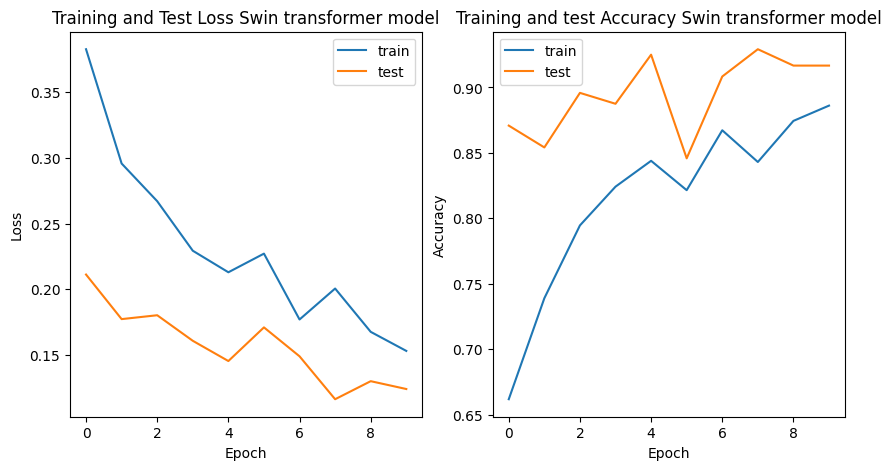

In [11]:
# Plot the validation and training loss and accuracy values
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(train_val_losses, label='train')
ax[0].plot(test_losses, label='test')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training and Test Loss Swin transformer model')
ax[0].legend()
ax[1].plot(train_val_accuracies, label='train')
ax[1].plot(test_accuracies, label='test')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Training and test Accuracy Swin transformer model')
ax[1].legend()
plt.show()

## Test performance Swin transformer model

In [12]:
# load in testset
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = ImageFolder(test_path, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

In [13]:
model.eval()
test_loss = 0.0
y_true = []
y_pred = []
Y_pred_prob = []

with torch.no_grad():
   for i in test_loader:

          #LOAD THE DATA IN A BATCH
          data, target = i

          # moving the tensors to the configured device
          data, target = data.to(DEVICE), target.to(DEVICE)

          target = target.float()
          output = model(data.float())

          loss = criterion(output, target.unsqueeze(1))
          test_loss += loss.item() * data.size(0)


          #PREDICTIONS
          pred_prop = torch.sigmoid(output)
          pred = torch.round(torch.sigmoid(output))

          y_true.extend(target.tolist())
          y_pred.extend(pred.reshape(-1).tolist())
          Y_pred_prob.extend(pred_prop.reshape(-1).tolist())

test_loss /= len(test_loader.sampler)
test_accuracy = accuracy_score(y_true,y_pred)

# get the specificity, sensitivity and g-mean
cm = confusion_matrix(y_true, y_pred)

# Extract the elements of the confusion matrix
tn, fp, fn, tp = cm.ravel()

# Calculate specificity and sensitivity
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

g_mean = imblearn.metrics.geometric_mean_score(y_true, y_pred)


print()
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1score = f1_score(y_true, y_pred)
f1score_macro = f1_score(y_true, y_pred, average = 'macro')
auc_roc = roc_auc_score(y_true, Y_pred_prob)

# Print the evaluation metrics
print('Test_loss:', test_loss)
print('Accuracy:', test_accuracy)
print()

print('Specificity:', specificity)
print('Sensitivity:', sensitivity)
print('g_mean:', g_mean)
print()

print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1score)
print('F1_score_macro:', f1score_macro)
print('AUC-ROC:', auc_roc)
print()

print(classification_report(y_true, y_pred))


Test_loss: 0.12418145065506299
Accuracy: 0.9166666666666666

Specificity: 0.8571428571428571
Sensitivity: 0.9292929292929293
g_mean: 0.8924891016347463

Precision: 0.968421052631579
Recall: 0.9292929292929293
F1-score: 0.9484536082474226
F1_score_macro: 0.8655311519497983
AUC-ROC: 0.9616402116402116

              precision    recall  f1-score   support

         0.0       0.72      0.86      0.78        42
         1.0       0.97      0.93      0.95       198

    accuracy                           0.92       240
   macro avg       0.84      0.89      0.87       240
weighted avg       0.92      0.92      0.92       240



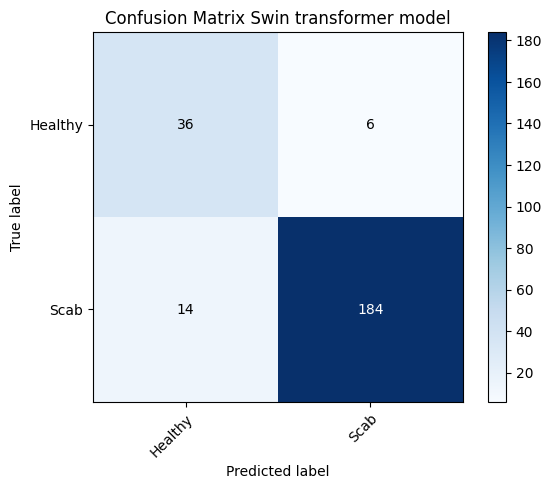

In [14]:
import matplotlib.pyplot as plt

# Create a confusion matrix:
cm = confusion_matrix(y_true, y_pred)

# Define the class labels
classes = np.unique(['Healthy', 'Scab'])

# Create the plot
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Add axis labels and tick marks
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes,
       yticklabels=classes,
       xlabel='Predicted label',
       ylabel='True label')

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2. else "black")

# Add a title and show plot
ax.set_title("Confusion Matrix Swin transformer model")
plt.show()